# Fringe Banks in Chicago:
- A few years ago, after being recommended and reading [Fringe Banking: Check-Cashing Outlets, Pawnshops, and the poor](https://www.amazon.com/Fringe-Banking-Check-Cashing-Outlets-Pawnshops/dp/0871541807) by a mentor of mine I became much more interested in the determinants of Fringe Bank location. The text and other studies on this subject often leverage expensive trade data on branch locations. To circumvent this, I chose to scrape yellow pages for a number of Fringe Bank keywords (dropping duplicates by address) and plot these locations against the FDIC Summary of Deposits data. 
- Unfortunately this approach doesn't allow me to study branch locations over time, but makes for great Python practice! In this notebook I leverage a few useful packages/methods:
1. Webscraping python using user defined functions and functions imported from _requests_.
2. Geocoding addresses using _censusgeocode_
3. Using shapefiles and plotting points by latitude and longitude

In [4]:
import requests
from lxml import html
import argparse
import csv
import pandas as pd
import glob



Here I define a function __parse_listing()__ that will scrape the name, location, phone number, and other data from _https://www.yellowpages.com_. 

In [7]:
#Define our function to scrape yellow pages data. 
#Iterating over each available page by search keyword

def parse_listing(keyword,place,page):
	"""	
	Function to process yellowpage listing page 
	: param keyword: search query
    : param place : place name
	: param page : page number
	"""
	url = "https://www.yellowpages.com/search?search_terms={0}&geo_location_terms={1}&page={2}".format(keyword,place,page)
	print("retrieving ",url)

	headers = {'Accept':'text/html,application/xhtml+xml,application/xml;q=0.9,image/webp,image/apng,*/*;q=0.8',
				'Accept-Encoding':'gzip, deflate, br',
				'Accept-Language':'en-GB,en;q=0.9,en-US;q=0.8,ml;q=0.7',
				'Cache-Control':'max-age=0',
				'Connection':'keep-alive',
				'Host':'www.yellowpages.com',
				'Upgrade-Insecure-Requests':'1',
				'User-Agent':'Mozilla/5.0 (X11; Linux x86_64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/64.0.3282.140 Safari/537.36'
			}
	# Adding retries
	for retry in range(10):
		try:
			response = requests.get(url,verify=False, headers = headers )
			print("parsing page")         
			if response.status_code==200:
				parser = html.fromstring(response.text)
				#making links absolute
				base_url = "https://www.yellowpages.com"
				parser.make_links_absolute(base_url)

				XPATH_LISTINGS = "//div[@class='search-results organic']//div[@class='v-card']" 
				listings = parser.xpath(XPATH_LISTINGS)
				scraped_results = []

				for results in listings:
					XPATH_BUSINESS_NAME = ".//a[@class='business-name']//text()" 
					XPATH_BUSSINESS_PAGE = ".//a[@class='business-name']//@href" 
					XPATH_TELEPHONE = ".//div[@class='phones phone primary']//text()"
					XPATH_ADDRESS = ".//div[@class='info']//div//p[@itemprop='address']"
					XPATH_STREET = ".//div[@class='street-address']//text()"
					XPATH_LOCALITY = ".//div[@class='locality']//text()"
					XPATH_REGION = ".//div[@class='info']//div//p[@itemprop='address']//span[@itemprop='addressRegion']//text()"
					XPATH_ZIP_CODE = ".//div[@class='info']//div//p[@itemprop='address']//span[@itemprop='postalCode']//text()"
					XPATH_RANK = ".//div[@class='info']//h2[@class='n']/text()"
					XPATH_CATEGORIES = ".//div[@class='info']//div[contains(@class,'info-section')]//div[@class='categories']//text()"
					XPATH_WEBSITE = ".//div[@class='info']//div[contains(@class,'info-section')]//div[@class='links']//a[contains(@class,'website')]/@href"
					XPATH_RATING = ".//div[@class='info']//div[contains(@class,'info-section')]//div[contains(@class,'result-rating')]//span//text()"
                    

					raw_business_name = results.xpath(XPATH_BUSINESS_NAME)
					raw_business_telephone = results.xpath(XPATH_TELEPHONE)	
					raw_business_page = results.xpath(XPATH_BUSSINESS_PAGE)
					raw_categories = results.xpath(XPATH_CATEGORIES)
					raw_website = results.xpath(XPATH_WEBSITE)
					raw_rating = results.xpath(XPATH_RATING)
					#address = results.xpath(XPATH_ADDRESS)
					raw_street = results.xpath(XPATH_STREET)
					raw_locality = results.xpath(XPATH_LOCALITY)
					raw_region = results.xpath(XPATH_REGION)
					raw_zip_code = results.xpath(XPATH_ZIP_CODE)
					raw_rank = results.xpath(XPATH_RANK)
					
					business_name = ''.join(raw_business_name).strip() if raw_business_name else None
					telephone = ''.join(raw_business_telephone).strip() if raw_business_telephone else None
					business_page = ''.join(raw_business_page).strip() if raw_business_page else None
					rank = ''.join(raw_rank).replace('.\xa0','') if raw_rank else None
					category = ','.join(raw_categories).strip() if raw_categories else None
					website = ''.join(raw_website).strip() if raw_website else None
					rating = ''.join(raw_rating).replace("(","").replace(")","").strip() if raw_rating else None
					street = ''.join(raw_street).strip() if raw_street else None
					locality = ''.join(raw_locality).replace(',\xa0','').strip() if raw_locality else None
					region = ''.join(raw_region).strip() if raw_region else None
					zipcode = ''.join(raw_zip_code).strip() if raw_zip_code else None


					business_details = {
										'business_name':business_name,
										'telephone':telephone,
										'business_page':business_page,
										'rank':rank,
										'category':category,
										'website':website,
										'rating':rating,
										'street':street,
										'locality':locality,
										'region':region,
										'zipcode':zipcode,
										'listing_url':response.url
					}
					scraped_results.append(business_details)

				return scraped_results

			elif response.status_code==404:
				print("Could not find a location matching",place)
				#no need to retry for non existing page
				break
			else:
				print("Failed to process page")
				return []
				
		except:
			print("Failed to process page")
			return []

I then use __parse_listing()__ to loop through a list of common _Fringe Banking_ terms. While the html of a given _yellowpages_ search does not provide any values representing the number of _hits_ nor available pages, I iterate through every available page by first checking whether or not the _dataFrame_ read is empty, and skipping to the next keyword if empty.

In [9]:
%%capture
#Turning warnings off for url requests, and hiding output of webscraping
import warnings
warnings.filterwarnings('ignore')
#Loop over each keyword and each available page
keywords = ['payday loans','pawnshop', 'cash advance','car title loan','check cashing']
place = "Chicago, IL"
page =1   
fringe_bank = pd.DataFrame()

for key in keywords:
    while pd.DataFrame(parse_listing(key,place,page)).empty==False:
        scraped_data =  pd.DataFrame(parse_listing(key,place,page))
        scraped_data['keyword'] = key 
        print(key)

        fringe_bank = pd.concat([fringe_bank,scraped_data],axis=0)
        page = page + 1
    page = 1
fringe_bank = fringe_bank.drop_duplicates(subset=['street','locality'],keep = 'first')


In order to get the latitude, longitude, census tract, and census block, I use the _censusgeocode_ package to loop through each address and pull these values. 

In [ ]:
#Geocode by street address-locality(zip,state) using census geocoder
import censusgeocode as cg

fringe_bank['Address'] =fringe_bank.street.str.cat(fringe_bank.locality,sep=" ")

fringe_bank['x'] = None
fringe_bank['y'] = None
fringe_bank['STATE'] = None
fringe_bank['GEOID'] = None
fringe_bank['BLOCK'] = None
fringe_bank['TRACT'] = None
i=0
x=0
# initializing split word
spl_word = ['x','y','STATE','GEOID','BLOCK','TRACT']
for i in list(range(len(fringe_bank))):
        result = str(cg.onelineaddress(fringe_bank['Address'].iloc[i],
                               returntype = 'geographies')).replace("'", '').replace(":","")
        if result == '[]':
            "empty list"
        else:
            for x in list(range(len(spl_word))):
                tmp = result.partition(spl_word[x])[2].split()[0].replace(",", '').replace("}","")
                fringe_bank[spl_word[x]].iloc[i] = tmp


I then read in the most recently available Summary of Deposits data (2019) to find individual branch locations. I subset the data _BRSERTYPE_ == 11, to only keep "Brick and Mortor" locations.

In [16]:
#Read in our bank branch locatinons from publicly available
#FDIC Summary of Deposits data. Using most recent data available (2019)


from io import BytesIO
from zipfile import ZipFile
from urllib.request import urlopen

link = "https://www7.fdic.gov/sod/download/ALL_2020.ZIP"
resp = urlopen(link)
# read zipfile
zipfile = ZipFile(BytesIO(resp.read()))
# get the csv file name
fname = zipfile.namelist()[0]
# convert to pandas dateframe
bank = pd.read_csv(zipfile.open(fname), encoding = 'unicode_escape', engine ='python')
#file to brick and mortor branches
bank = bank[bank.BRSERTYP.isin([11]) ]
bank = bank[bank.STALPBR == "IL"]

In [19]:
import matplotlib.pyplot as plt
import descartes
import geopandas as gpd
from shapely.geometry import Point, Polygon


Finally, I plot these Fringe Bank locations along with traditional bank branch locations, over a great shapefile containing Chicago street center lines available at (https://data.cityofchicago.org/Transportation/Street-Center-Lines/6imu-meau)

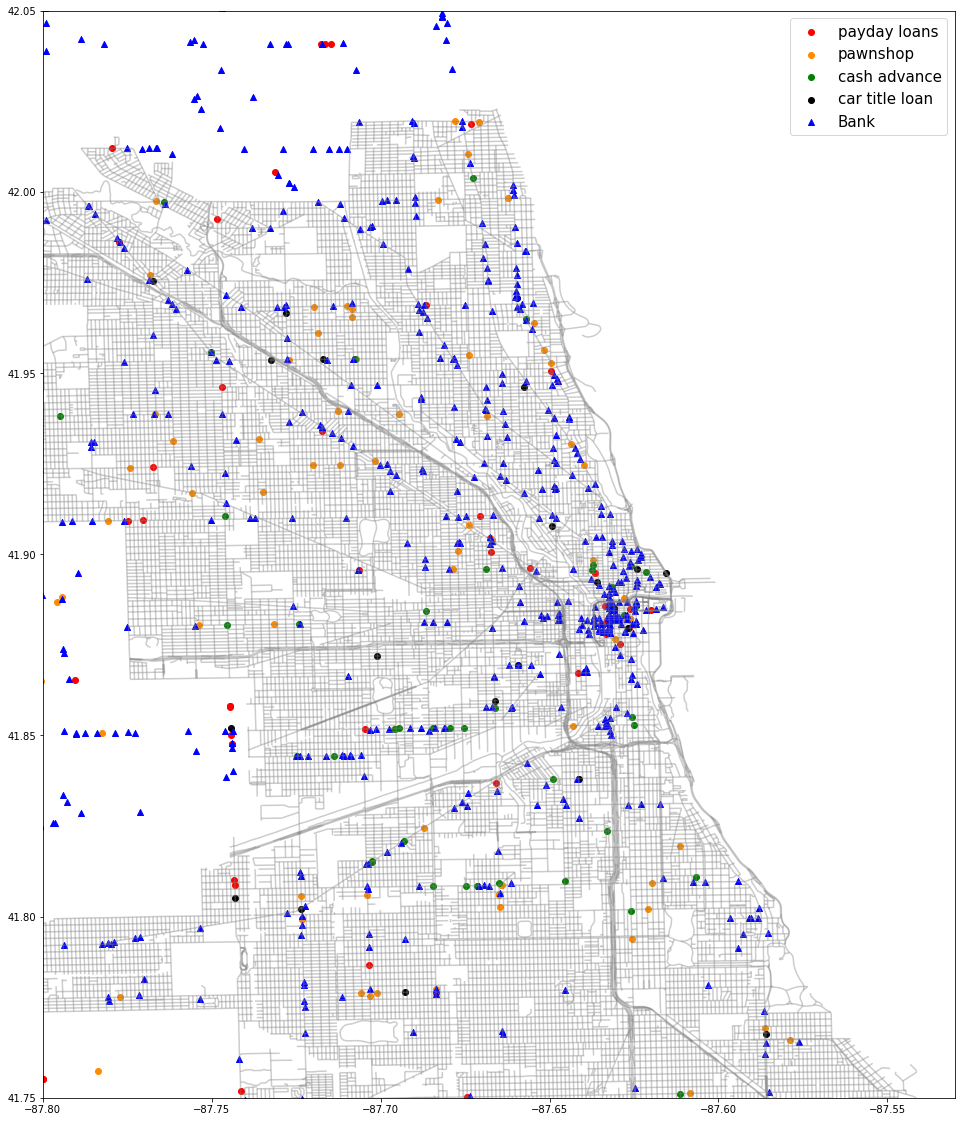

In [48]:
##Plot bank locations against fringe-bank locations

#Read Chicago Street shape file
street_map = gpd.read_file('data///geo_export_ed330fc1-9479-4dd3-bd8a-66d9234bcb19.shp')

#Need to Coerce long and lat to numeric
fringe_bank['x'] = pd.to_numeric(fringe_bank['x'], errors ='coerce')
fringe_bank['y'] = pd.to_numeric(fringe_bank['y'], errors ='coerce')

#Create point objects
geometry_pay = [Point(xy) for xy in zip( fringe_bank['x'],fringe_bank['y'])]
geometry_bank = [Point(xy) for xy in zip( bank['SIMS_LONGITUDE'],bank['SIMS_LATITUDE'])]

crs = {'init':'epsg:4326'}
pay_df= gpd.GeoDataFrame(fringe_bank,
                        crs=crs,
                        geometry=geometry_pay)

bank_df= gpd.GeoDataFrame(bank,
                        crs=crs,
                        geometry=geometry_bank)

colors = {'payday loans':'red', 'pawnshop':'darkorange','check cashing':'purple','cash advance':'green', 'car title loan':'black'}

#plot
fix,ax = plt.subplots(figsize=(20,20))
street_map.plot(ax=ax,alpha=0.4, color = 'grey').axes.set_xlim(-87.8,-87.53)
for key in pay_df['keyword'].unique():
    pay_df.loc[pay_df['keyword'] == key].plot(ax=ax,color =colors[key],marker="o",label=key).axes.set_ylim(41.75,42.05)
bank_df.plot(ax=ax,color = "blue", marker="^",label="Bank")
plt.legend(prop={'size':15})

In [49]:
#read in geocoded sod
bank = pd.read_csv('data/sod_geocoded.csv')

#group by block, summarise count ( call bank_count)
bank = bank.groupby(['ZIPBR', 'TRACT']).agg({'ADDRESBR': ['count']}).reset_index()
#rename columns 
bank.columns = ['ZIPBR', 'TRACT', 'bank_count']

#Create new Fringe Bank dataframe
fringe =fringe_bank
fringe['ZIPBR'] = fringe.locality.str.extract(r'\b(\w+)$', expand=True)
fringe = fringe.groupby(['ZIPBR', 'TRACT']).agg({'street': ['count']}).reset_index()
fringe.columns = ['ZIPBR', 'TRACT', 'fringe_count']
fringe['ZIPBR'] = fringe['ZIPBR'].astype(int)

In [60]:
import statsmodels.formula.api as smf

cols = ['ZIPBR','TRACT','fringe_count']
fringe[cols]= fringe[cols].apply(pd.to_numeric, errors='coerce')

df_merge_col = pd.merge(bank, fringe, on= ['ZIPBR','TRACT'],how = 'outer')
df_merge_col = df_merge_col.fillna(0)


FE_ols = smf.ols(formula='fringe_count ~ bank_count',
                              data=df_merge_col).fit()
print(FE_ols.summary())


                            OLS Regression Results                            
Dep. Variable:           fringe_count   R-squared:                       0.009
Model:                            OLS   Adj. R-squared:                  0.008
Method:                 Least Squares   F-statistic:                     16.24
Date:                Fri, 21 May 2021   Prob (F-statistic):           5.82e-05
Time:                        15:53:45   Log-Likelihood:                -1359.1
No. Observations:                1801   AIC:                             2722.
Df Residuals:                    1799   BIC:                             2733.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.2486      0.020     12.682      0.0

In [61]:
# Create API calls
import requests
apiKey = "[[079bcce00c1691acd723c6bebd6489e4f4e10721]]"
